In [1]:
from __future__ import division
def feature_eng(y, fs, vis=False):
    
    import librosa
    import librosa.display
    import numpy as np
    import maad
    from soundsig.sound import BioSound
    import matplotlib.pyplot as plt
    import pandas as pd

    # spectrum
    ps = np.abs(np.fft.fft(y))**2
    time_step = 1/fs
    freqs = np.fft.fftfreq(y.size, time_step)
    ps = ps[0:int((len(ps)/2)-1)] # take out the negative freq
    freqs = freqs[0:int((len(freqs)/2)-1)]

    # melspectrogram
    S = librosa.feature.melspectrogram(y=y, sr=fs)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # alpha indices
    Sxx_power,tn,fn,ext = maad.sound.spectrogram (y, fs, mode='psd')
    df_temporal_indices = maad.features.all_temporal_alpha_indices(y, fs)
    df_spectral_indices, _ = maad.features.all_spectral_alpha_indices(Sxx_power,tn,fn, extent=ext)
    df_indices = pd.concat([df_temporal_indices,df_spectral_indices], axis=1)
    
    # soundsig for modulation power spectrum
    
    myBioSound = BioSound(soundWave=y, fs=fs)
    myBioSound.mpsCalc(window=0.1, Norm = True)
    
    if vis==True:
        plt.figure()
        plt.plot(np.arange(0,y.size/fs,1/fs), y)
        plt.show()
        
        fig, ax = plt.subplots()
        img = librosa.display.specshow(S_dB, x_axis='time',
                                 y_axis='mel', sr=fs,
                                 fmax=fs/2, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')
        
        DBNOISE=50
        plt.figure()
        plt.clf()
        cmap = plt.get_cmap('jet')
        ex = (myBioSound.wt.min(), myBioSound.wt.max(), myBioSound.wf.min()*1e3, myBioSound.wf.max()*1e3)
        logMPS = 10.0*np.log10(myBioSound.mps)
        maxMPS = logMPS.max()
        minMPS = maxMPS-DBNOISE
        logMPS[logMPS < minMPS] = minMPS
        plt.imshow(logMPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
        plt.ylabel('Spectral Frequency (Cycles/KHz)')
        plt.xlabel('Temporal Frequency (Hz)')
        plt.colorbar()
        plt.ylim((0,myBioSound.wf.max()*1e3))
        plt.title('Modulation Power Spectrum')
        plt.show()
        
    
    return ps, S_dB, df_indices, myBioSound.mps, myBioSound.wt, myBioSound.wf
    

In [2]:
def preproc(file, fs=16000, vis=False):
    import librosa
    import numpy as np
    import matplotlib.pyplot as plt
    import noisereduce as nr
    
    raw_y, fs = librosa.load(file, sr=fs, duration=10, mono = True)
    y_mono_rs = raw_y - np.mean(raw_y) # remove DC
    rms = np.sqrt(np.mean(y_mono_rs**2)) # get rms
    y = y_mono_rs/(rms/0.1) # normalize the rms to 0.1
    
    fg_y = nr.reduce_noise(y=y, sr=fs)
    bg_y = y - fg_y
    
    
    if vis == True: print('++++++++++++++++++++++++ raw ++++++++++++++++++++++++')
    ps, S_dB, df_indices, mps, wt, wf = feature_eng(y, fs, vis)
    if vis == True: print('++++++++++++++++++++ foreground ++++++++++++++++++++')
    ps_fg, S_dB_fg, df_indices_fg, mps_fg, wt_fg, wf_fg = feature_eng(fg_y, fs, vis)
    if vis == True: print('++++++++++++++++++++ background ++++++++++++++++++++')
    ps_bg, S_dB_bg, df_indices_bg, mps_bg, wt_bg, wf_bg = feature_eng(bg_y, fs, vis)
    
    return 
    

++++++++++++++++++++++++ raw ++++++++++++++++++++++++


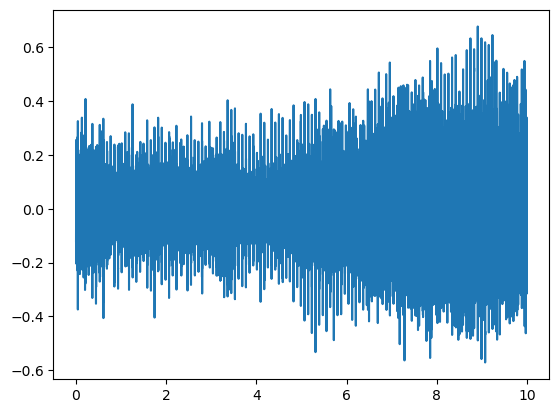

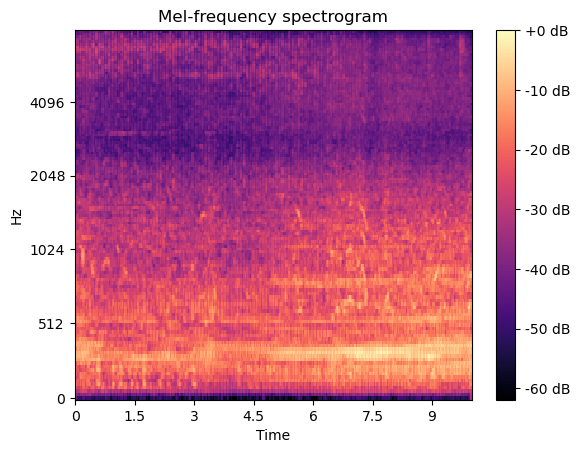

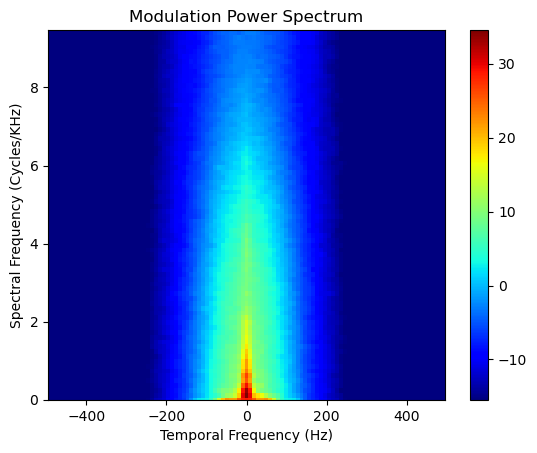

++++++++++++++++++++ foreground ++++++++++++++++++++


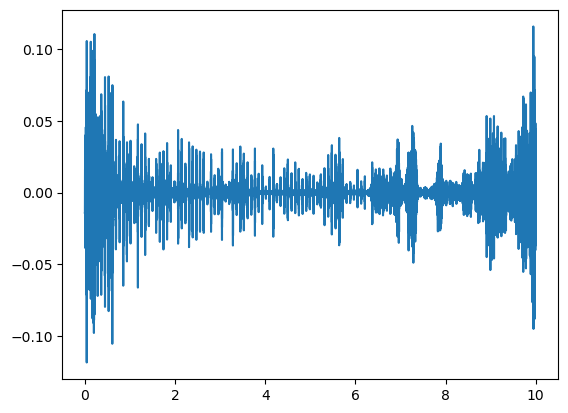

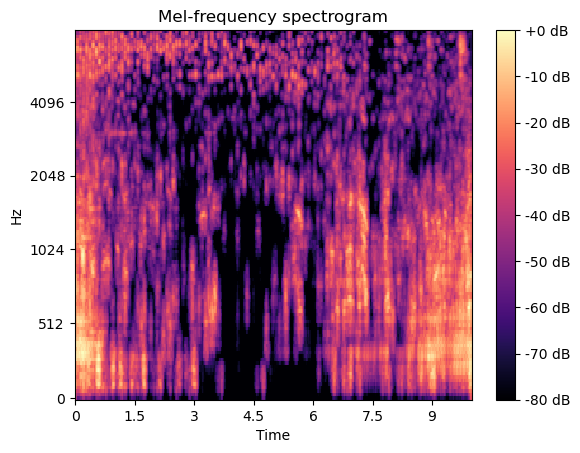

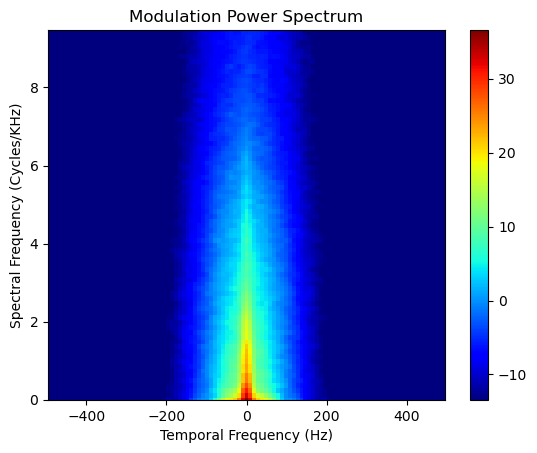

++++++++++++++++++++ background ++++++++++++++++++++


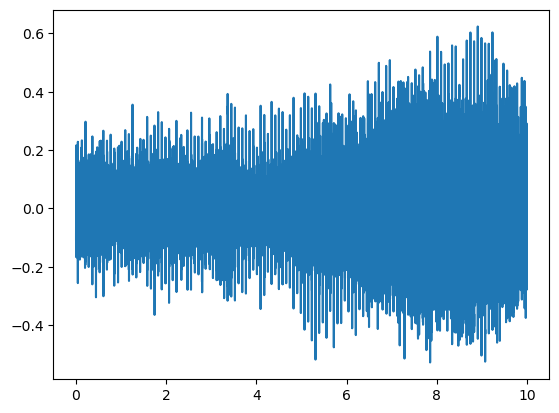

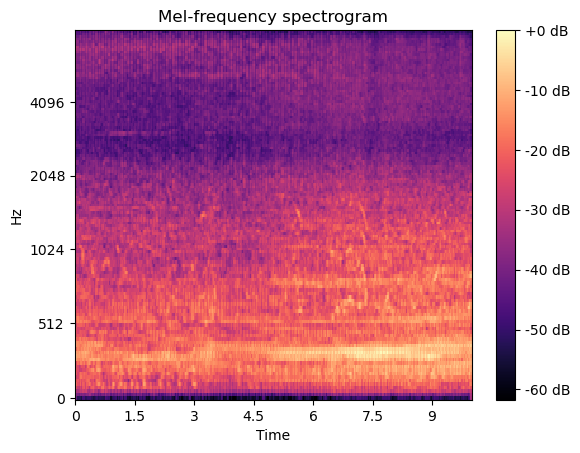

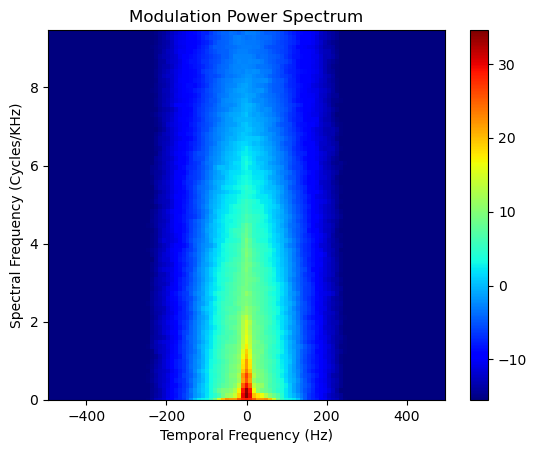

--- 6.165575981140137 seconds ---


In [7]:
import time
start_time = time.time()

preproc('/Users/andrewchang/Springboard_GitHub/Capstone_AcousticEnv/data/raw/GoogleAudioSet/Outside, rural or natural/5B7lDpIYNj0_510.wav', vis = True)

print("--- %s seconds ---" % (time.time() - start_time))

# below are experiments

In [2]:
file = '../data/raw/youtube/NomadicAmbience_city/_dWyKj7I9JM_266.m4a'
# file = '../data/raw/youtube/NatureSoundscapes/_y_1VGCbzko_854.m4a'
y, fs = librosa.load(file, sr=16000, duration=10, mono = True)

y_mono_rs = y - np.mean(y) # remove DC
rms = np.sqrt(np.mean(y_mono_rs**2)) # get rms
y_mono_rs_norm = y_mono_rs/(rms/0.1) # normalize the rms to 0.1

/Users/andrewchang/opt/anaconda3/envs/AcousticEnv/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


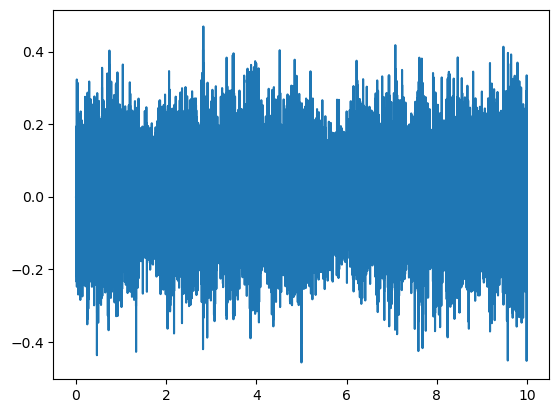

In [3]:
plt.plot(np.arange(0,10,1/16000), y_mono_rs_norm)
plt.show()

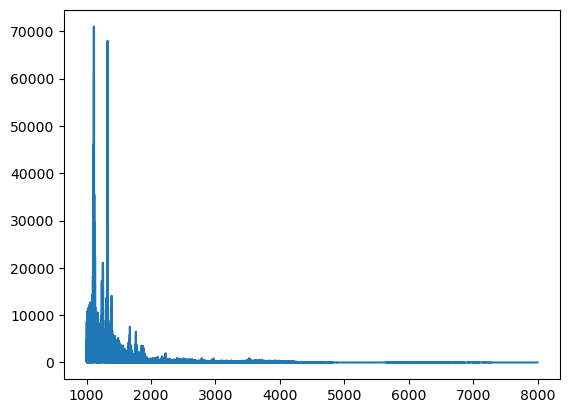

In [4]:
from __future__ import division


ps = np.abs(np.fft.fft(y_mono_rs_norm))**2

time_step = 1 / 16000
freqs = np.fft.fftfreq(y_mono_rs_norm.size, time_step)

ps = ps[0:int((len(ps)/2)-1)]
freqs = freqs[0:int((len(freqs)/2)-1)]

plt.plot(freqs[10000:], ps[10000:])


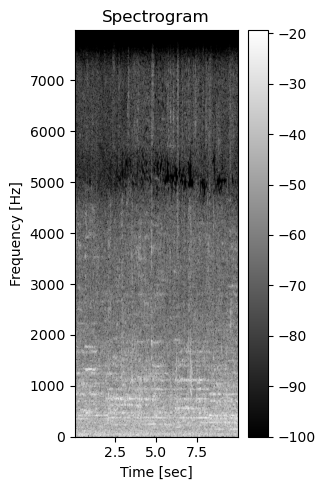

/Users/andrewchang/opt/anaconda3/envs/AcousticEnv/lib/python3.8/site-packages/maad/features/shape.py:343: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im_pyr = tuple(transform.pyramid_gaussian(Sxx, downscale=2,
/Users/andrewchang/opt/anaconda3/envs/AcousticEnv/lib/python3.8/site-packages/maad/features/shape.py:359: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im = transform.rescale(im, scale = ratio, mode='reflect',


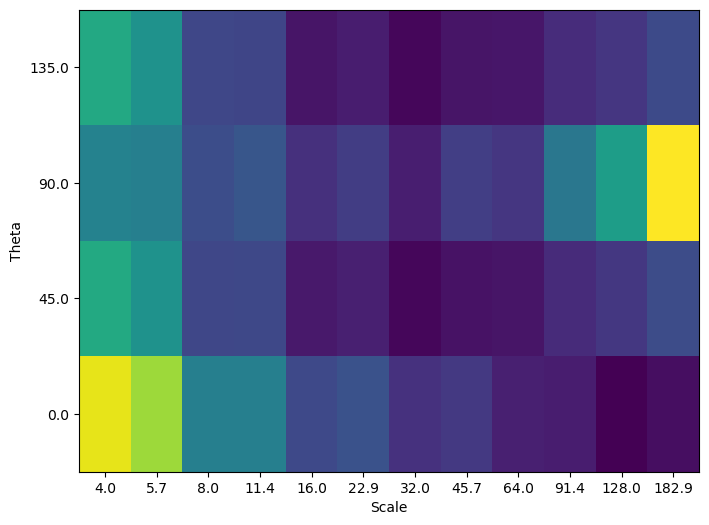

In [5]:
from maad.sound import load, spectrogram 
from maad.features import shape_features
from maad.util import format_features, power2dB, plot_shape 

Sxx, tn, fn, ext = spectrogram(y_mono_rs_norm, 16000, db_range=100, display=True) 
Sxx_db = power2dB(Sxx, db_range=100)
shape, params = shape_features(Sxx_db, resolution='med') 
ax = plot_shape(shape.mean(), params) 

In [50]:
shape

,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,shp_007,shp_008,shp_009,shp_010,...,shp_039,shp_040,shp_041,shp_042,shp_043,shp_044,shp_045,shp_046,shp_047,shp_048
0,0.139841,0.15252,0.082976,0.096561,0.06985,0.074318,0.082369,0.096323,0.081921,0.082173,...,0.03503,0.028303,0.056501,0.040828,0.050207,0.039782,0.112202,0.081673,0.05252,0.040366


In [51]:
params

,theta,freq,pyr_level,scale
0,0.0,0.35,1.0,2.857143
1,0.0,0.50,1.0,2.000000
2,45.0,0.35,1.0,2.857143
3,45.0,0.50,1.0,2.000000
4,90.0,0.35,1.0,2.857143
5,90.0,0.50,1.0,2.000000
6,135.0,0.35,1.0,2.857143
7,135.0,0.50,1.0,2.000000
8,0.0,0.35,2.0,2.857143
9,0.0,0.50,2.0,2.000000


In [6]:
import noisereduce as nr
reduced_noise = nr.reduce_noise(y=y_mono_rs_norm, sr=16000)


In [7]:
from scipy.io import wavfile
wavfile.write("mywav_reduced_noise.wav", 16000, reduced_noise)

In [8]:
aa = y_mono_rs_norm-reduced_noise
wavfile.write("aa.wav", 16000, aa)

In [9]:
len(aa)

160000

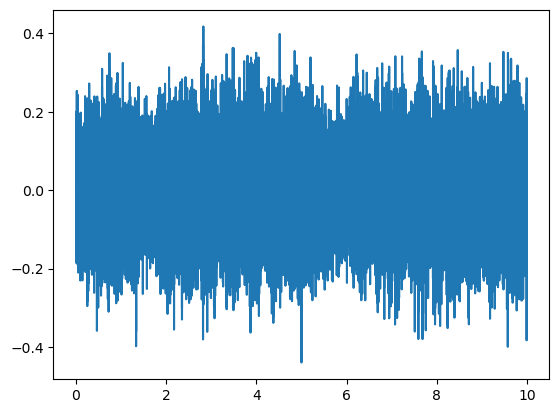

In [10]:
plt.plot(np.arange(0,10,1/16000), aa)
plt.show()

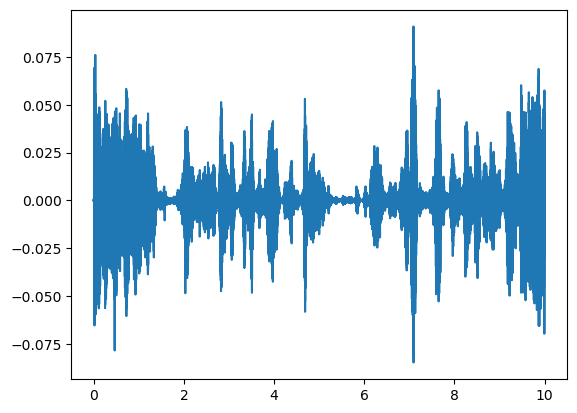

In [11]:
plt.plot(np.arange(0,10,1/16000), reduced_noise)
plt.show()

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_98040/760385283.py:4: FutureWarning: Pass y=[4.45378391e-05 2.17246893e-03 1.12398097e-03 ... 1.93896323e-01
 1.47886947e-01 1.12143345e-01], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = melspectrogram(y_mono_rs_norm, fs)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

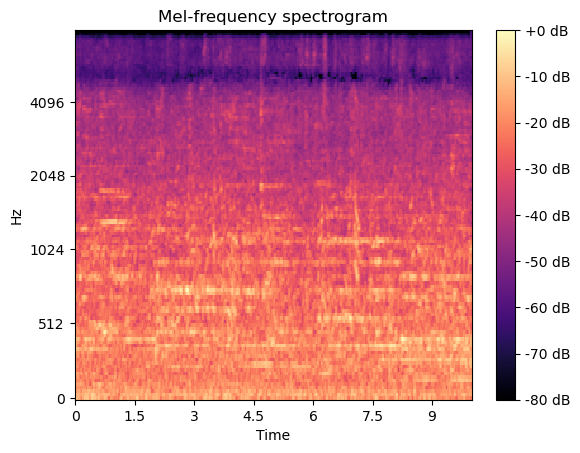

In [15]:
import librosa
import librosa.display
from librosa.feature import melspectrogram
S = melspectrogram(y_mono_rs_norm, fs)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=fs,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_98040/3206079643.py:1: FutureWarning: Pass y=[-8.0728882e-05  2.5984959e-04  8.4858017e-05 ...  2.8349075e-02
  2.0757126e-02  1.8250210e-02], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = melspectrogram(reduced_noise, fs)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

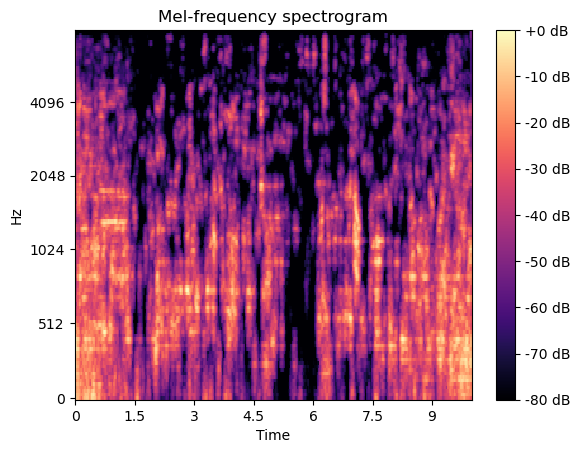

In [16]:
S = melspectrogram(reduced_noise, fs)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=fs,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_98040/2423342128.py:1: FutureWarning: Pass y=[1.2526673e-04 1.9126193e-03 1.0391229e-03 ... 1.6554725e-01 1.2712982e-01
 9.3893133e-02], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = melspectrogram(aa, fs)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

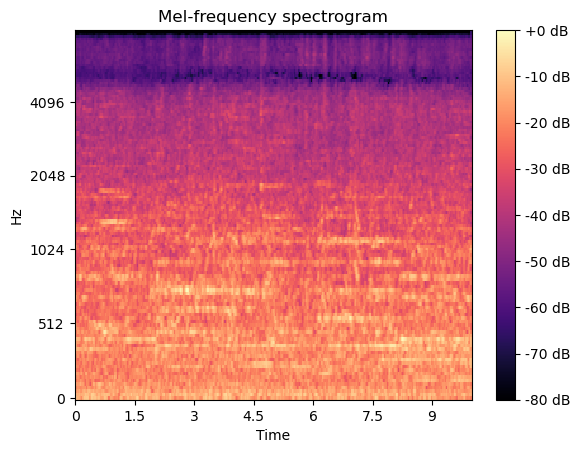

In [17]:
S = melspectrogram(aa, fs)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=fs,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [18]:
S

array([[9.40911007e+00, 2.71884346e+01, 1.67435513e+01, ...,
        3.09736514e+00, 3.81939816e+00, 2.44209218e+00],
       [3.50299597e+00, 1.78231163e+01, 1.45949612e+01, ...,
        6.33191729e+00, 1.12792931e+01, 1.38249197e+01],
       [1.88592219e+00, 6.55951023e+00, 8.42041302e+00, ...,
        5.79001474e+00, 6.14042234e+00, 9.39002800e+00],
       ...,
       [5.37137603e-05, 8.54110331e-05, 6.85891282e-05, ...,
        8.18249973e-05, 7.80188784e-05, 2.71515804e-04],
       [2.42102828e-06, 3.14018598e-06, 4.02383102e-06, ...,
        1.01150281e-05, 1.11397039e-05, 1.04271567e-04],
       [1.08640066e-07, 1.76941867e-07, 9.20278609e-08, ...,
        7.04324705e-08, 2.42035571e-06, 8.30502759e-05]], dtype=float32)

ZCR 1472.80000
MEANt 0.00000
VARt 0.01000
SKEWt -0.00794
KURTt 3.24671
LEQt 73.02060
SNRt 0.44258
BGNt -11.14534
MED 0.27716
Ht 0.98622
ACTtFraction 0.04167
ACTtCount 13.00000
ACTtMean 3.70167
EVNtFraction 0.04167
EVNtMean 0.03200
EVNtCount 1.30627


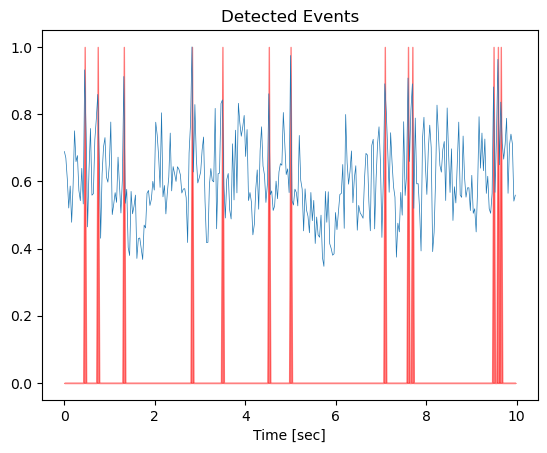

In [20]:
import maad
df_temporal_indices = maad.features.all_temporal_alpha_indices(y_mono_rs_norm, fs, verbose=True, display=True)

In [21]:
df_temporal_indices

,ZCR,MEANt,VARt,SKEWt,KURTt,LEQt,BGNt,SNRt,MED,Ht,ACTtFraction,ACTtCount,ACTtMean,EVNtFraction,EVNtMean,EVNtCount
0,1472.8,6.347894e-10,0.01,-0.007945,3.246714,73.020601,-11.145341,0.442581,0.277162,0.986215,0.041667,13,3.701674,0.041667,0.032,1.30627


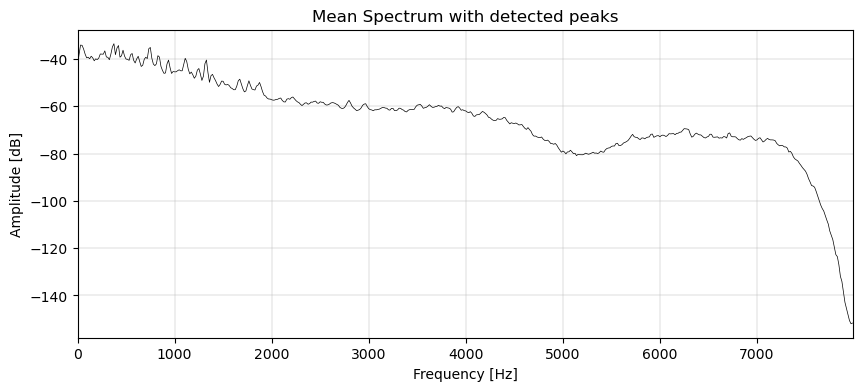

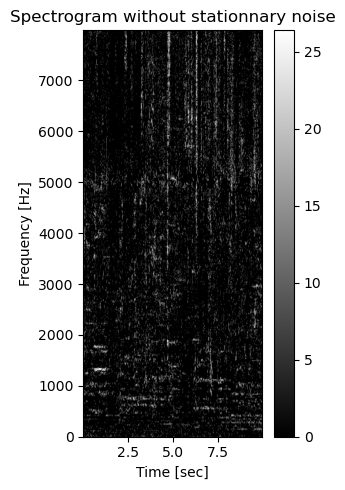

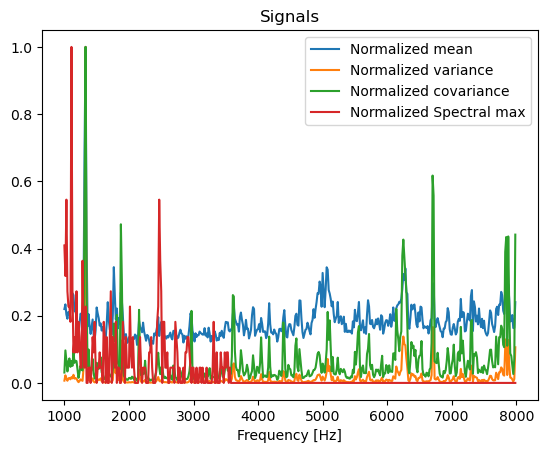

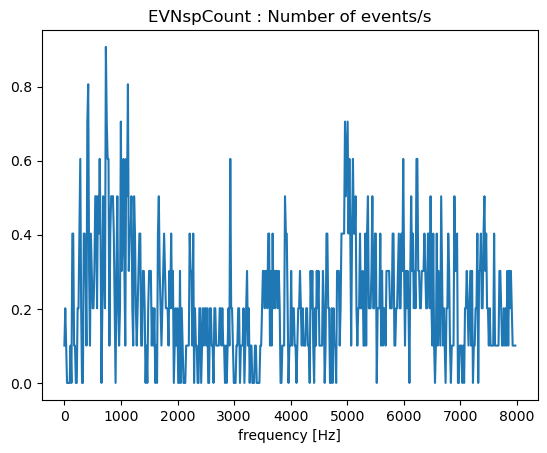

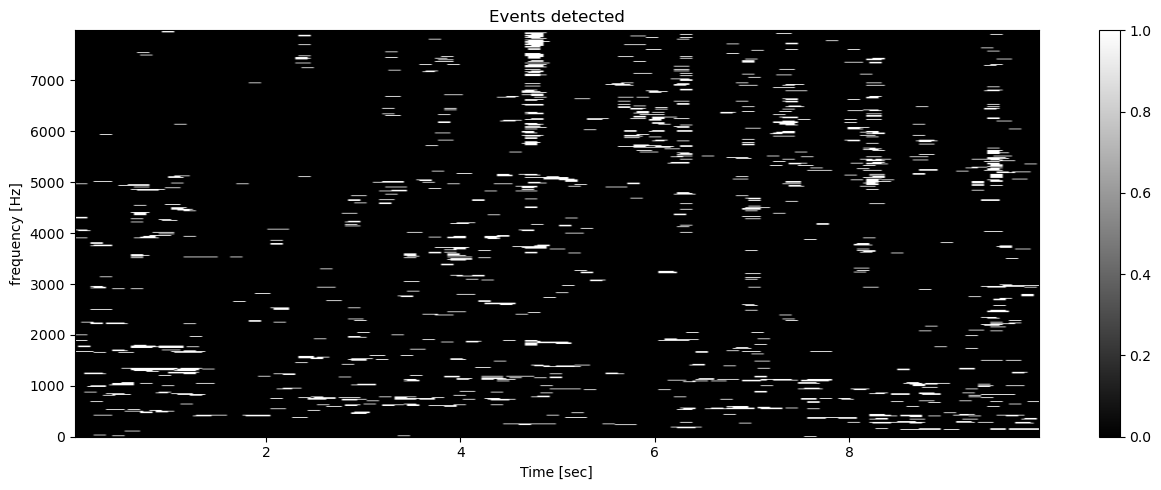

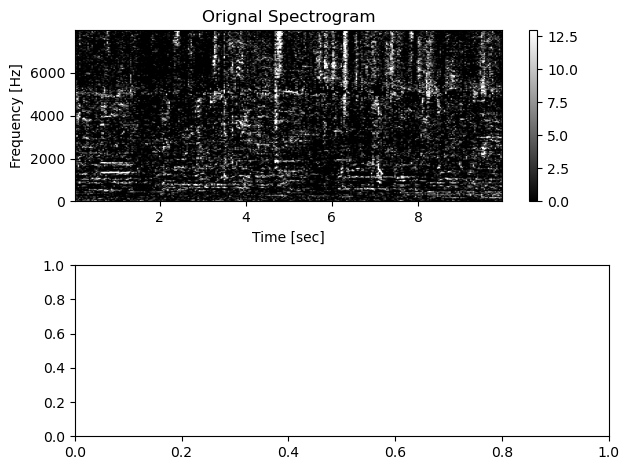

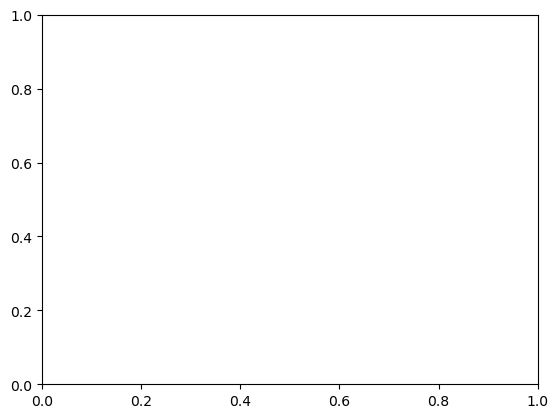

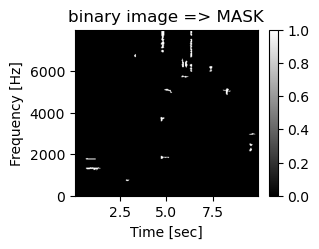

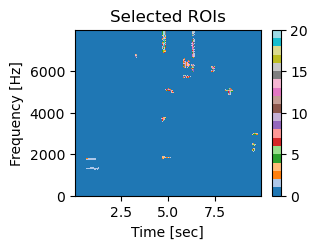

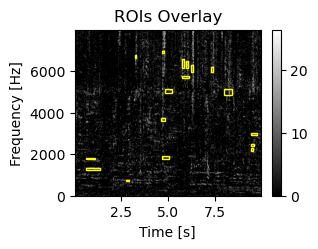

In [23]:
Sxx_power,tn,fn,ext = maad.sound.spectrogram (y_mono_rs_norm, fs)  
df_spectral_indices_DAY, _ = maad.features.all_spectral_alpha_indices(Sxx_power,tn,fn,display=True, extent=ext)

In [25]:
df_spectral_indices_DAY.columns

Index(['MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf', 'ENRf', 'BGNf',
       'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI',
       'NDSI', 'rBA', 'AnthroEnergy', 'BioEnergy', 'BI', 'ROU', 'ADI', 'AEI',
       'LFC', 'MFC', 'HFC', 'ACTspFract', 'ACTspCount', 'ACTspMean',
       'EVNspFract', 'EVNspMean', 'EVNspCount', 'TFSD', 'H_Havrda', 'H_Renyi',
       'H_pairedShannon', 'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI',
       'ROItotal', 'ROIcover'],
      dtype='object')

In [26]:
df_temporal_indices.columns

Index(['ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'MED',
       'Ht', 'ACTtFraction', 'ACTtCount', 'ACTtMean', 'EVNtFraction',
       'EVNtMean', 'EVNtCount'],
      dtype='object')